In [1886]:
#Author: Vinicius Bueno de Moraes
#Case - Risk Intern - NEO Investimentos
#2022, January

#All on a Daily Basis - Port. Return, etc.

#Results achieved through Python are tabulated/explicit throughout this notebook, in accordance with question 2 of the Case.


In [1887]:
#Libraries & Paths
import pandas as pd
from sqlalchemy import create_engine
import pandasql as ps
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt

In [1888]:
#Close IBOV - To DataFrame
dataIBOV = pd.read_excel('Base de Dados.xlsx', sheet_name = 'IBOV')

#IBOV Lin. Return (%)
dataIBOV['Return (%)'] = (dataIBOV["Price"].pct_change(periods = -1))*100
display(dataIBOV)

,Date,Instrument,Price,Return (%)
0,2022-01-10,IBOV,101945.20,-0.753771
1,2022-01-07,IBOV,102719.47,1.140614
2,2022-01-06,IBOV,101561.05,0.549880
3,2022-01-05,IBOV,101005.64,-2.422869
4,2022-01-04,IBOV,103513.64,-0.392556
...,...,...,...,...
1006,2018-01-08,IBOV,79285.81,0.271033
1007,2018-01-05,IBOV,79071.50,0.539191
1008,2018-01-04,IBOV,78647.44,0.836270
1009,2018-01-03,IBOV,77995.19,0.133687


In [1889]:
#1a. - Return Assets (with IBOV) - To DataFrame (Decimal Values)
dataAssets = (pd.read_excel('Base de Dados.xlsx', sheet_name = 'Data', header = 1)).drop(['Day'], axis = 1)
dataAssets['IBOV'] = dataIBOV['Return (%)']/100

#DataFrame Query
q1 = """SELECT * FROM dataAssets"""
dataAssets = ps.sqldf(q1, locals())
display(dataAssets)


,Stocks,Bonds,Gold,Commodities,Tbill,IBOV
0,-0.027088,-0.0321,0.016949,0.034158,0.0044,-0.007538
1,-0.042402,0.0014,0.287879,0.043358,0.0041,0.011406
2,-0.006743,0.0082,0.058824,-0.023813,0.0046,0.005499
3,-0.047598,0.0046,0.008000,0.060363,0.0052,-0.024229
4,-0.021724,-0.0105,0.264881,0.182372,0.0051,-0.003926
...,...,...,...,...,...,...
487,-0.026893,-0.0132,0.061050,0.033762,0.0000,0.001241
488,0.037167,0.0121,-0.048934,-0.033916,0.0000,-0.009393
489,0.041783,0.0147,-0.001885,-0.014426,0.0000,0.017445
490,0.030903,-0.0255,-0.053625,-0.007811,0.0000,-0.032899


In [1890]:
#1b. - Statistics
dataStats = pd.DataFrame()
dataStats['Mean - Daily Return'] = dataAssets.mean(axis = 0)
dataStats['Std. Dev. - Daily Return'] = dataAssets.std(axis = 0)
dataStats['Sharpe Ratio - Monthly'] = ((dataStats['Mean - Daily Return']-dataStats.loc['Tbill', 'Mean - Daily Return'])/dataStats['Std. Dev. - Daily Return'])*(30**.5)
display(dataStats)

,Mean - Daily Return,Std. Dev. - Daily Return,Sharpe Ratio - Monthly
Stocks,0.009388,0.046131,0.612584
Bonds,0.007158,0.031473,0.509750
Gold,0.007725,0.060449,0.316821
Commodities,0.008230,0.058800,0.372733
Tbill,0.004229,0.002777,0.000000
IBOV,-0.000077,0.022003,-1.071855


In [1891]:
#1c. - Covariance Matrix (Only for Stocks, Bonds, Gold and Commodities)
covMat = pd.DataFrame()
covMat = (dataAssets.drop(['Tbill', 'IBOV'], axis=1).cov())*252
display(covMat)


,Stocks,Bonds,Gold,Commodities
Stocks,0.536277,0.040633,0.004264,0.073514
Bonds,0.040633,0.249612,0.007765,-0.048214
Gold,0.004264,0.007765,0.920814,0.231551
Commodities,0.073514,-0.048214,0.231551,0.871266


In [1892]:
#Export DataFrames to Excel Files
writer = pd.ExcelWriter('My Processed Data.xlsx', engine='xlsxwriter')

dataAssets.to_excel(writer, sheet_name='Return - Assets')
dataStats.to_excel(writer, sheet_name='Statistics - Assets')
covMat.to_excel(writer, sheet_name='Cov Matrix')

writer.save()

#1d., e. - Continue the Excel part with document generated here

In [1893]:
#1d., e. - Optimization with Python / Efficient Frontier Approach
numAssets = 4 #Stocks, Bonds, Gold and Commodities
portfolio = dataAssets.drop(columns=['Tbill', 'IBOV'])
returnMean = dataStats.iloc[0:numAssets, 0]
portReturns = []
portStdDev = []
portWeigths = []
nSimulations = 10000

#Define Values - Find N Situations/Portfolios
for i in range(nSimulations):
    weigths = np.random.random(numAssets)
    weigths = weigths/np.sum(weigths)
    portWeigths.append(weigths)
    returns = np.dot(weigths, returnMean)
    portReturns.append(returns)

    var = covMat.mul(weigths, axis = 0).mul(weigths, axis = 1).sum().sum()
    stdDevAn = (np.sqrt(var))
    portStdDev.append(stdDevAn)

#Organize Data for Visualization
data = {'Expected Return' : portReturns, 'Std. Dev.' : portStdDev}
for counter, symbol in enumerate(portfolio.columns.tolist()):
    data[symbol+ ' weight'] = [w[counter] for w in portWeigths]

#Convert to DataFrame  
rangeOfPortfolios = pd.DataFrame(data)
display(rangeOfPortfolios)

,Expected Return,Std. Dev.,Stocks weight,Bonds weight,Gold weight,Commodities weight
0,0.007717,0.487322,0.049292,0.358802,0.367954,0.223951
1,0.008020,0.506131,0.132703,0.253879,0.181676,0.431742
2,0.007974,0.648061,0.021470,0.156382,0.224154,0.597993
3,0.007637,0.459440,0.032188,0.433170,0.329114,0.205528
4,0.008013,0.424649,0.212814,0.319920,0.238458,0.228809
...,...,...,...,...,...,...
9995,0.008040,0.686195,0.122951,0.025932,0.602698,0.248419
9996,0.008200,0.466083,0.323937,0.216978,0.342270,0.116814
9997,0.008236,0.471158,0.283315,0.188111,0.239194,0.289380
9998,0.007831,0.567730,0.015043,0.379417,0.018107,0.587434


In [1894]:
#Maximal Sharpe Ratio Approach (MSR)

riskFree = dataStats.at['Tbill', 'Mean - Daily Return']

optimalMaxSharpe = rangeOfPortfolios.iloc[((rangeOfPortfolios['Expected Return']-riskFree)/rangeOfPortfolios['Std. Dev.']).idxmax()]
print(optimalMaxSharpe)

Expected Return       0.008087
Std. Dev.             0.386786
Stocks weight         0.318305
Bonds weight          0.428188
Gold weight           0.104116
Commodities weight    0.149391
Name: 165, dtype: float64


In [1895]:
#Global Mimimum Var. Approach (GMV)

optimalMinVar = rangeOfPortfolios.iloc[rangeOfPortfolios['Std. Dev.'].idxmin()]
print(optimalMinVar)

Expected Return       0.007822
Std. Dev.             0.373124
Stocks weight         0.197408
Bonds weight          0.547306
Gold weight           0.098801
Commodities weight    0.156485
Name: 4278, dtype: float64


Text(0, 0.5, 'Expected Return')

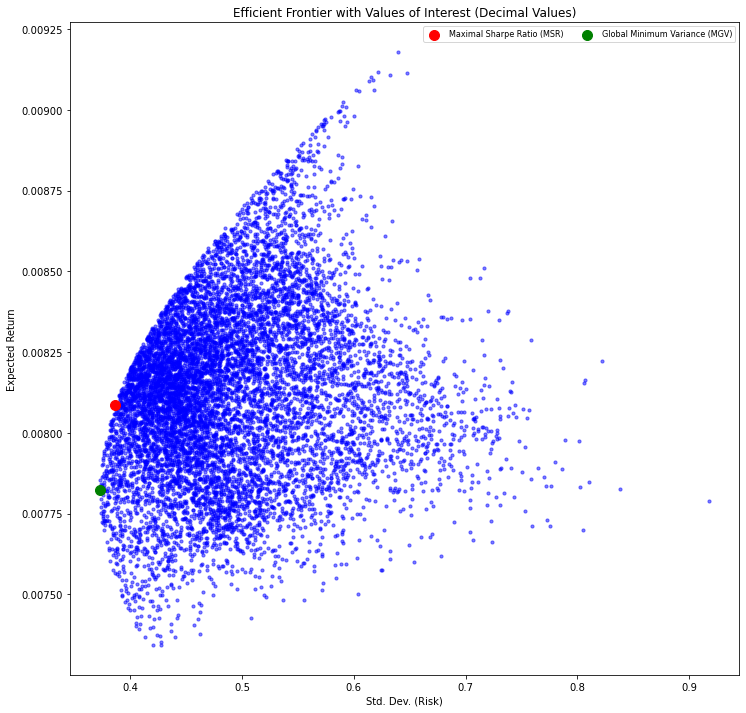

In [1896]:
#Plot Efficient Frontier - Values ​​of Interest (MSR and GMV)

plt.subplots(figsize=(12, 12))

#Efficient Frontier
plt.scatter(rangeOfPortfolios['Std. Dev.'], rangeOfPortfolios['Expected Return'], marker = 'o', s = 10, alpha = 0.5, color = 'blue')

#Point of MSR
msr = plt.scatter(optimalMaxSharpe[1], optimalMaxSharpe[0], color='r', marker='o',  s=100)

#Point of MGV
gmv = plt.scatter(optimalMinVar[1], optimalMinVar[0], color='g', marker='o',  s=100)

#Information
plt.legend((msr, gmv),
           ('Maximal Sharpe Ratio (MSR)', 'Global Minimum Variance (MGV)'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
plt.title('Efficient Frontier with Values of Interest (Decimal Values)')
plt.xlabel('Std. Dev. (Risk)')
plt.ylabel('Expected Return')

